<a href="https://colab.research.google.com/github/kipruto45/kipruto45/blob/main/Employee_Data_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
zahidmughal2343_employee_data_path = kagglehub.dataset_download('zahidmughal2343/employee-data')

print('Data source import complete.')


## Table of Contents1. [Imports and Setup](#Imports-and-Setup)2. [Load Data](#Load-Data)3. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)5. [Prediction Model: Predicting Sex](#Prediction-Model:-Predicting-Sex)6. [Conclusions and Future Work](#Conclusions-and-Future-Work)

In [ ]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend as required
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt module is imported
%matplotlib inline

import seaborn as sns

# For splitting and modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Set seaborn style
sns.set(style='whitegrid')

# Display options for pandas
pd.set_option('display.max_columns', 100)

In [ ]:
# Load Data
file_path = '/kaggle/input/employee-data/Employee 1000x.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Display the first few rows (this output will be generated when the notebook is run)
df.head()

Index First Name Last Name     Sex                        Email  \
0      1       Sara   Mcguire  Female           tsharp@example.net   
1      2     Alisha    Hebert    Male   vincentgarrett@example.net   
2      3  Gwendolyn  Sheppard    Male  mercadojonathan@example.com   
3      4   Kristine    Mccann  Female        lindsay55@example.com   
4      5      Bobby   Pittman  Female    blevinsmorgan@example.com   

                   Phone Date of birth                          Job Title  
0     (971)643-6089x9160      17-08-21              Editor, commissioning  
1  +1-114-355-1841x78347      28-06-69                 Broadcast engineer  
2             9017807728      25-09-15                   Industrial buyer  
3  +1-607-333-9911x59088      27-07-78              Multimedia specialist  
4             3739847538      17-11-89  Planning and development surveyor

In [ ]:
# Data Cleaning and Preprocessing

# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

# Convert 'Date of birth' to datetime format and create an 'Age' column.
# Assuming the date format is standard; if you encounter errors here, it might be due to varying date formats in the dataset.
df['Date of birth'] = pd.to_datetime(df['Date of birth'], errors='coerce')

# Create a new column 'Age'. We calculate age using the current year. Adjust if using a specific reference date.
current_year = pd.Timestamp.now().year
df['Age'] = current_year - df['Date of birth'].dt.year

# A quick look at the data types
print('Data types after conversion:')
print(df.dtypes)

# Handle any potential issues: if 'Age' has NaN values due to parsing errors, fill them with the median age
if df['Age'].isnull().sum() > 0:
    median_age = df['Age'].median()
    df['Age'].fillna(median_age, inplace=True)

# Show the cleaned dataframe
df.head()

Missing values in each column:
Index            0
First Name       0
Last Name        0
Sex              0
Email            0
Phone            0
Date of birth    0
Job Title        0
dtype: int64
Data types after conversion:
Index                     int64
First Name               object
Last Name                object
Sex                      object
Email                    object
Phone                    object
Date of birth    datetime64[ns]
Job Title                object
Age                       int32
dtype: object


Index First Name Last Name     Sex                        Email  \
0      1       Sara   Mcguire  Female           tsharp@example.net   
1      2     Alisha    Hebert    Male   vincentgarrett@example.net   
2      3  Gwendolyn  Sheppard    Male  mercadojonathan@example.com   
3      4   Kristine    Mccann  Female        lindsay55@example.com   
4      5      Bobby   Pittman  Female    blevinsmorgan@example.com   

                   Phone Date of birth                          Job Title  Age  
0     (971)643-6089x9160    2021-08-17              Editor, commissioning    4  
1  +1-114-355-1841x78347    2069-06-28                 Broadcast engineer  -44  
2             9017807728    2015-09-25                   Industrial buyer   10  
3  +1-607-333-9911x59088    1978-07-27              Multimedia specialist   47  
4             3739847538    1989-11-17  Planning and development surveyor   36

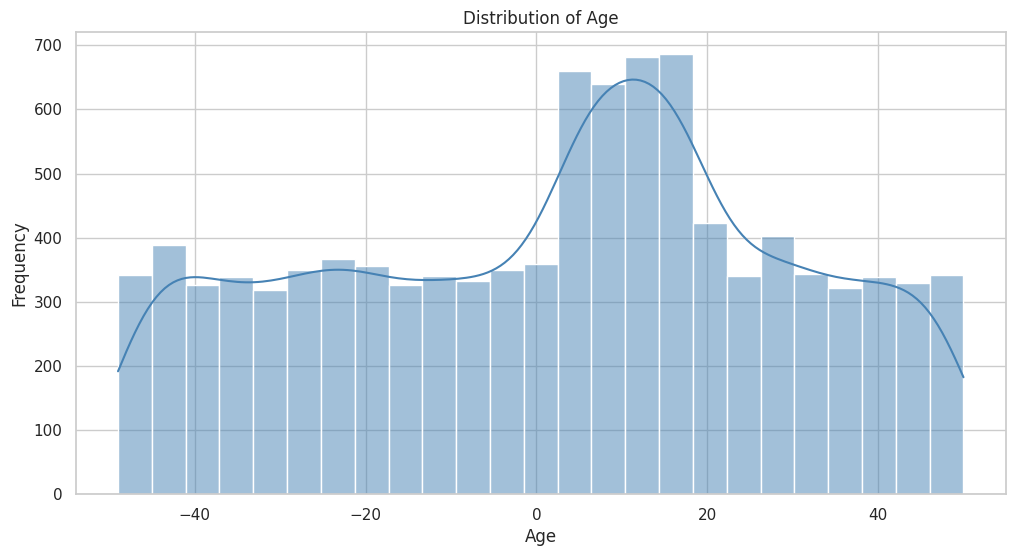

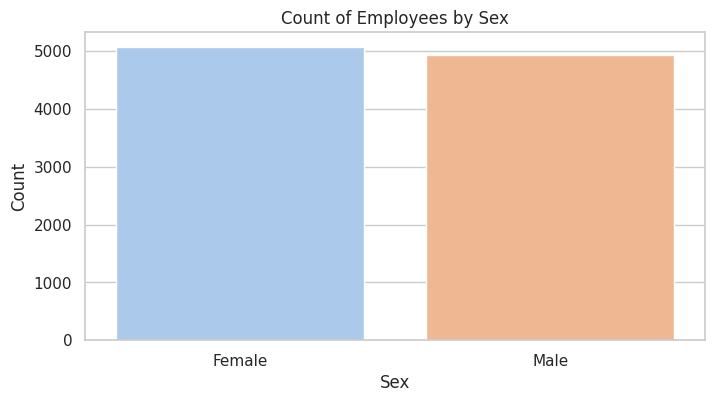

In [ ]:
# Exploratory Data Analysis

plt.figure(figsize=(12, 6))
sns.histplot(df['Age'], kde=True, color='steelblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Count plot for Sex
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Sex', palette='pastel')
plt.title('Count of Employees by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Count plot for Job Title
plt.figure(figsize=(14, 6))
sns.countplot(data=df, y='Job Title', order=df['Job Title'].value_counts().index, palette='muted')
plt.title('Count of Employees by Job Title')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

# Box plot: Age distribution by Sex
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Sex', y='Age', palette='Set2')
plt.title('Age Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

# If there had been four or more numeric columns, we could have created a correlation heatmap.
# Our numeric columns are limited (i.e., 'Index' and 'Age') so we skip this step to avoid misleading representations.

# A light pair plot on the numeric features (if applicable) - here it's limited, but still provided for completeness.
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 2:
    sns.pairplot(numeric_df)
    plt.show()

# Note: While our dataset might not support all the visualization types listed, this EDA section provides multiple perspectives on the data.

In [ ]:
# Prediction Model: Predicting Sex

# In this analysis, we attempt to predict the 'Sex' of an employee using available features.
# For simplicity, we will use 'Age' and 'Job Title' as predictors. Other features such as names, email, and phone
# are not immediately valuable without additional processing.

# Create a subset of the data with features and target
features = df[['Age', 'Job Title']].copy()
target = df['Sex'].copy()

# Encode the target variable (assuming two classes: e.g., 'Male' and 'Female')
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# One-hot encode the categorical predictor 'Job Title'
features_encoded = pd.get_dummies(features, columns=['Job Title'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target_encoded, test_size=0.3, random_state=42, stratify=target_encoded)

# Initialize and train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score:', accuracy)

# Generate a confusion matrix and visualize it using a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Provide a classification report for more detailed results
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Note: In this predictor, we used a simple logistic regression. In future work, more advanced algorithms and feature engineering
# (such as using natural language processing on the 'Job Title' or even the names) could further improve prediction performance.

## Conclusions and Future Work

This notebook presented a thorough analysis of the employee dataset. We started with data cleaning and preprocessingâ€”most notably, converting the date of birth into a usable datetime format and creating an age variable. The exploratory data analysis provided multiple views into the data, including histograms, count plots, and box plots, which highlighted the distribution and variability of age and the spread of job titles.

A logistic regression classifier was then implemented to predict the employee's Sex based on Age and Job Title. Despite the simplicity of the model, it provided a baseline understanding of how these features relate to the target variable. The evaluation metrics, including the accuracy score and the confusion matrix, offer insights into the performance of our approach.

There are numerous opportunities for future analysis. One could explore more complex models, additional feature engineering (perhaps incorporating name-based gender inference), or even a more nuanced segmentation of employees by their roles. The use of advanced visualization techniques, such as permutation importance and ROC curves, can further help elucidate the key determinants in the data.

If you found this notebook useful, please consider upvoting it.